Name: Ying Wang

Github Username: Notrew

USC ID: 9965632493

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn import tree 
from sklearn.tree import _tree
from sklearn.model_selection import GridSearchCV,cross_val_score,KFold
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso,LassoCV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import xgboost as xgb

# from scipy import stats
# import random sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings("ignore")

### 1.b Build a decision tree on the whole data set and plot it
This data set is a multi-label data set. **Sk-Learn** seems to support building multi-label decision trees. Alternatively, you can use the **label powerset method** to convert it to a **multiclass data set**. Also, you can use the **binary relevance method** and **build one decision tree** for each label. 

In [2]:
df_diag = pd.read_csv("../data/diagnosis.data",encoding="utf-16",sep="\t",
            names=["Temperature","Nausea","Lumbar","Urine","Micturition","Urethra","Bladder","Pelvis"],header=None)
df_diag.head()

Temperature Nausea Lumbar Urine Micturition Urethra Bladder Pelvis
0        35,5     no    yes    no          no      no      no     no
1        35,9     no     no   yes         yes     yes     yes     no
2        35,9     no    yes    no          no      no      no     no
3        36,0     no     no   yes         yes     yes     yes     no
4        36,0     no    yes    no          no      no      no     no

In [3]:
df_diag["Temperature"] = df_diag["Temperature"].apply(lambda x : x.replace(",",".")).astype("float") 
df_diag.replace({"yes":1,"no":0},inplace=True)
df_diag.head()

Temperature  Nausea  Lumbar  Urine  Micturition  Urethra  Bladder  Pelvis
0         35.5       0       1      0            0        0        0       0
1         35.9       0       0      1            1        1        1       0
2         35.9       0       1      0            0        0        0       0
3         36.0       0       0      1            1        1        1       0
4         36.0       0       1      0            0        0        0       0

In [4]:
# build a decision tree on the whole data set
dtclf = tree.DecisionTreeClassifier() 
X = df_diag.iloc[:,:-2]
y = df_diag.iloc[:,-2:]
dtclf = dtclf.fit(X,y)

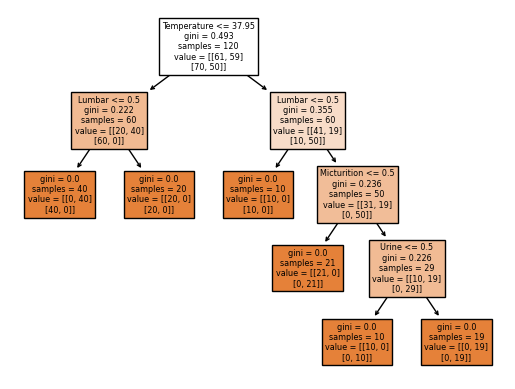

In [5]:
# plot the decision tree
tree.plot_tree(dtclf,feature_names=X.columns,filled=True)
plt.rcParams["figure.figsize"]=(8,8)
plt.show()

### 1.c Convert the decision rules into a set of IF-THEN rules
can use the code in https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

In [6]:
def tree_to_code(tree, feature_names):
    """
　　Outputs a decision tree model as a Python function
　　Parameters:
　　-----------
　　tree: decision tree model
　　　　The decision tree to represent as a function
　　feature_names: list
　　　　The feature names of the dataset used for building the decision tree
　　"""
    tree_ = tree.tree_
    feature_name = [
    feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [7]:
tree_to_code(dtclf,list(X.columns))

def tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Temperature <= 37.95000076293945:
    if Lumbar <= 0.5:
      return [[ 0. 40.]
 [40.  0.]]
    else:  # if Lumbar > 0.5
      return [[20.  0.]
 [20.  0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if Lumbar > 0.5
      if Micturition <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Micturition > 0.5
        if Urine <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if Urine > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### 1.d Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability
    

In [8]:
# find a minimal decision tree
path = dtclf.cost_complexity_pruning_path(X,y)
ccp_alphas = path.ccp_alphas
ccp_alphas

array([0.        , 0.04908333, 0.07947222, 0.11111111, 0.20423611])

In [9]:
param_grid = {"ccp_alpha":list(ccp_alphas)[1:]} #eliminate ccp_alpha = 0
grid_search = GridSearchCV(dtclf,param_grid,cv=5)
grid_search.fit(X,y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.04908333333333333, 0.07947222222222226,
                                       0.1111111111111111, 0.204236111111111]})

In [10]:
ccp_alpha = grid_search.best_params_["ccp_alpha"]
ccp_alpha

0.04908333333333333

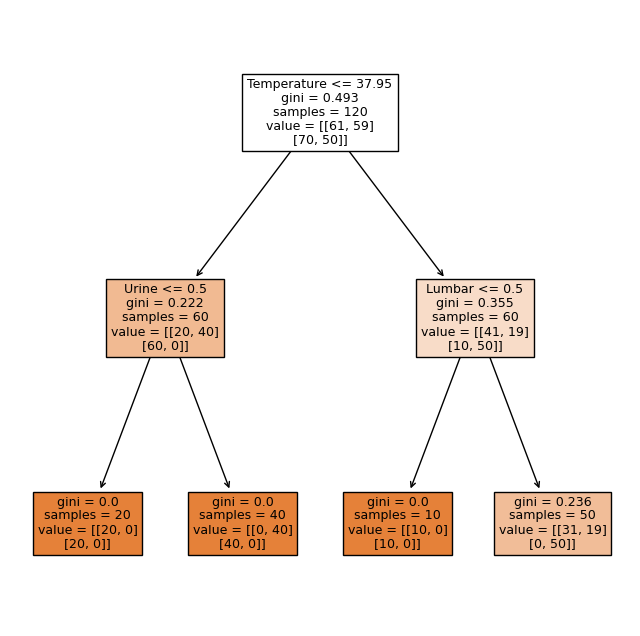

In [11]:
# refit decision tree use best ccp_alpha and plot it
dtclf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha) 
X = df_diag.iloc[:,:-2]
y = df_diag.iloc[:,-2:]
dtclf = dtclf.fit(X,y)
tree.plot_tree(dtclf,feature_names=X.columns,filled=True)
plt.rcParams["figure.figsize"]=(5,5)
plt.show()

In [12]:
# interprete it to if-then rules
tree_to_code(dtclf,list(X.columns))

def tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Temperature <= 37.95000076293945:
    if Urine <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if Urine > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if Temperature > 37.95000076293945
    if Lumbar <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if Lumbar > 0.5
      return [[31. 19.]
 [ 0. 50.]]


### 2. The LASSO and Boosting for Regression

### 2.a Use the first 1495 rows of data as the training set and the rest as the test set

In [13]:
df_com = pd.read_csv("../data/communities.data",header=None)
print(df_com.shape)
# the 128th columns is the goal attribute ViolentCrimesPerPop
df_com.head()

(1994, 128)


0   1      2                    3    4     5     6     7     8     9    \
0    8   ?      ?         Lakewoodcity    1  0.19  0.33  0.02  0.90  0.12   
1   53   ?      ?          Tukwilacity    1  0.00  0.16  0.12  0.74  0.45   
2   24   ?      ?         Aberdeentown    1  0.00  0.42  0.49  0.56  0.17   
3   34   5  81440  Willingborotownship    1  0.04  0.77  1.00  0.08  0.12   
4   42  95   6096    Bethlehemtownship    1  0.01  0.55  0.02  0.95  0.09   

   ...   118   119   120   121   122  123  124   125   126   127  
0  ...  0.12  0.26  0.20  0.06  0.04  0.9  0.5  0.32  0.14  0.20  
1  ...  0.02  0.12  0.45     ?     ?    ?    ?  0.00     ?  0.67  
2  ...  0.01  0.21  0.02     ?     ?    ?    ?  0.00     ?  0.43  
3  ...  0.02  0.39  0.28     ?     ?    ?    ?  0.00     ?  0.12  
4  ...  0.04  0.09  0.02     ?     ?    ?    ?  0.00     ?  0.03  

[5 rows x 128 columns]

In [14]:
# replace "?" to nan
df_com.replace("?",np.nan,inplace=True)
df_com.head()

0    1      2                    3    4     5     6     7     8     9    \
0    8  NaN    NaN         Lakewoodcity    1  0.19  0.33  0.02  0.90  0.12   
1   53  NaN    NaN          Tukwilacity    1  0.00  0.16  0.12  0.74  0.45   
2   24  NaN    NaN         Aberdeentown    1  0.00  0.42  0.49  0.56  0.17   
3   34    5  81440  Willingborotownship    1  0.04  0.77  1.00  0.08  0.12   
4   42   95   6096    Bethlehemtownship    1  0.01  0.55  0.02  0.95  0.09   

   ...   118   119   120   121   122  123  124   125   126   127  
0  ...  0.12  0.26  0.20  0.06  0.04  0.9  0.5  0.32  0.14  0.20  
1  ...  0.02  0.12  0.45   NaN   NaN  NaN  NaN  0.00   NaN  0.67  
2  ...  0.01  0.21  0.02   NaN   NaN  NaN  NaN  0.00   NaN  0.43  
3  ...  0.02  0.39  0.28   NaN   NaN  NaN  NaN  0.00   NaN  0.12  
4  ...  0.04  0.09  0.02   NaN   NaN  NaN  NaN  0.00   NaN  0.03  

[5 rows x 128 columns]

### 2.b 
The data set has missing values. Use a **data imputation** technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [15]:
# columns 0,1,2,3,4 are non-predictive
df_com = df_com.iloc[:,5:].apply(pd.to_numeric, errors='coerce')
df_com = df_com.fillna(df_com.mean())
df_com

5     6     7     8     9     10    11    12    13    14   ...   118  \
0     0.19  0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  0.32  ...  0.12   
1     0.00  0.16  0.12  0.74  0.45  0.07  0.26  0.59  0.35  0.27  ...  0.02   
2     0.00  0.42  0.49  0.56  0.17  0.04  0.39  0.47  0.28  0.32  ...  0.01   
3     0.04  0.77  1.00  0.08  0.12  0.10  0.51  0.50  0.34  0.21  ...  0.02   
4     0.01  0.55  0.02  0.95  0.09  0.05  0.38  0.38  0.23  0.36  ...  0.04   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1989  0.01  0.40  0.10  0.87  0.12  0.16  0.43  0.51  0.35  0.30  ...  0.01   
1990  0.05  0.96  0.46  0.28  0.83  0.32  0.69  0.86  0.73  0.14  ...  0.02   
1991  0.16  0.37  0.25  0.69  0.04  0.25  0.35  0.50  0.31  0.54  ...  0.08   
1992  0.08  0.51  0.06  0.87  0.22  0.10  0.58  0.74  0.63  0.41  ...  0.03   
1993  0.20  0.78  0.14  0.46  0.24  0.77  0.50  0.62  0.40  0.17  ...  0.11   

       119   120       121       122       123       124   125       126   127  
0     0.26  0.20  0.060000  0.040000  0.900000  0.500000  0.32  0.140000  0.20  
1     0.12  0.45  0.163103  0.076708  0.698589  0.440439  0.00  0.195078  0.67  
2     0.21  0.02  0.163103  0.076708  0.698589  0.440439  0.00  0.195078  0.43  
3     0.39  0.28  0.163103  0.076708  0.698589  0.440439  0.00  0.195078  0.12  
4     0.09  0.02  0.163103  0.076708  0.698589  0.440439  0.00  0.195078  0.03  
...    ...   ...       ...       ...       ...       ...   ...       ...   ...  
1989  0.28  0.05  0.163103  0.076708  0.698589  0.440439  0.00  0.195078  0.09  
1990  0.37  0.20  0.163103  0.076708  0.698589  0.440439  0.00  0.195078  0.45  
1991  0.32  0.18  0.080000  0.060000  0.780000  0.000000  0.91  0.280000  0.23  
1992  0.38  0.33  0.020000  0.020000  0.790000  0.000000  0.22  0.180000  0.19  
1993  0.30  0.05  0.080000  0.040000  0.730000  0.500000  1.00  0.130000  0.48  

[1994 rows x 123 columns]

In [16]:
col_names = []
f = open("../data/communities.names")
for line in f.readlines():
    if line.startswith("@attribute"):
        name = line.replace("@attribute ","").replace(" numeric\n","")
        col_names.append(name)
df_com.columns = col_names[5:]
df_com

population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1989        0.01           0.40          0.10          0.87          0.12   
1990        0.05           0.96          0.46          0.28          0.83   
1991        0.16           0.37          0.25          0.69          0.04   
1992        0.08           0.51          0.06          0.87          0.22   
1993        0.20           0.78          0.14          0.46          0.24   

      racePctHisp  agePct12t21  agePct12t29  agePct16t24  agePct65up  ...  \
0            0.17         0.34         0.47         0.29        0.32  ...   
1            0.07         0.26         0.59         0.35        0.27  ...   
2            0.04         0.39         0.47         0.28        0.32  ...   
3            0.10         0.51         0.50         0.34        0.21  ...   
4            0.05         0.38         0.38         0.23        0.36  ...   
...           ...          ...          ...          ...         ...  ...   
1989         0.16         0.43         0.51         0.35        0.30  ...   
1990         0.32         0.69         0.86         0.73        0.14  ...   
1991         0.25         0.35         0.50         0.31        0.54  ...   
1992         0.10         0.58         0.74         0.63        0.41  ...   
1993         0.77         0.50         0.62         0.40        0.17  ...   

      LandArea  PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  \
0         0.12     0.26            0.20   0.060000       0.040000   
1         0.02     0.12            0.45   0.163103       0.076708   
2         0.01     0.21            0.02   0.163103       0.076708   
3         0.02     0.39            0.28   0.163103       0.076708   
4         0.04     0.09            0.02   0.163103       0.076708   
...        ...      ...             ...        ...            ...   
1989      0.01     0.28            0.05   0.163103       0.076708   
1990      0.02     0.37            0.20   0.163103       0.076708   
1991      0.08     0.32            0.18   0.080000       0.060000   
1992      0.03     0.38            0.33   0.020000       0.020000   
1993      0.11     0.30            0.05   0.080000       0.040000   

      LemasPctPolicOnPatr  LemasGangUnitDeploy  LemasPctOfficDrugUn  \
0                0.900000             0.500000                 0.32   
1                0.698589             0.440439                 0.00   
2                0.698589             0.440439                 0.00   
3                0.698589             0.440439                 0.00   
4                0.698589             0.440439                 0.00   
...                   ...                  ...                  ...   
1989             0.698589             0.440439                 0.00   
1990             0.698589             0.440439                 0.00   
1991             0.780000             0.000000                 0.91   
1992             0.790000             0.000000                 0.22   
1993             0.730000             0.500000                 1.00   

      PolicBudgPerPop  ViolentCrimesPerPop  
0            0.140000                 0.20  
1            0.195078                 0.67  
2            0.195078                 0.43  
3            0.195078                 0.12  
4            0.195078                 0.03  
...               ...                  ...  
1989         0.195078                 0.09  
1990         0.195078                 0.45  
1991         0.280000                 0.23  
1992         0.180000   

In [17]:
com_train = df_com.iloc[:1495]
com_test = df_com.iloc[1495:]

### 2.c Plot a correlation matrix for the features in the data set

In [18]:
corr = df_com.corr()
corr

population  householdsize  racepctblack  racePctWhite  \
population             1.000000      -0.046148      0.231178     -0.300845   
householdsize         -0.046148       1.000000     -0.067109     -0.235907   
racepctblack           0.231178      -0.067109      1.000000     -0.794389   
racePctWhite          -0.300845      -0.235907     -0.794389      1.000000   
racePctAsian           0.181603       0.201996     -0.106738     -0.270266   
...                         ...            ...           ...           ...   
LemasPctPolicOnPatr   -0.061583      -0.006426     -0.082660      0.052940   
LemasGangUnitDeploy    0.076527      -0.000280      0.010987     -0.033209   
LemasPctOfficDrugUn    0.466352      -0.094368      0.260793     -0.276234   
PolicBudgPerPop       -0.035576      -0.054562      0.022237     -0.006323   
ViolentCrimesPerPop    0.367157      -0.034923      0.631264     -0.684770   

                     racePctAsian  racePctHisp  agePct12t21  agePct12t29  \
population               0.181603     0.156218     0.006368     0.130344   
householdsize            0.201996     0.468659     0.520461     0.367338   
racepctblack            -0.106738    -0.066581     0.122338     0.153475   
racePctWhite            -0.270266    -0.444166    -0.194015    -0.266852   
racePctAsian             1.000000     0.266743    -0.025020     0.100727   
...                           ...          ...          ...          ...   
LemasPctPolicOnPatr      0.032389     0.024366     0.000652     0.013327   
LemasGangUnitDeploy      0.065424     0.025956     0.011271     0.005145   
LemasPctOfficDrugUn      0.101888     0.125353     0.001301     0.117290   
PolicBudgPerPop         -0.011619     0.002234    -0.076589    -0.068575   
ViolentCrimesPerPop      0.037622     0.293050     0.060477     0.153357   

                     agePct16t24  agePct65up  ...  LandArea   PopDens  \
population              0.075596   -0.102006  ...  0.713652  0.231897   
householdsize           0.295225   -0.612666  ... -0.015078 -0.004072   
racepctblack            0.134068    0.052934  ...  0.149758  0.095053   
racePctWhite           -0.183804    0.136483  ... -0.131389 -0.337458   
racePctAsian            0.052761   -0.272020  ... -0.001084  0.389944   
...                          ...         ...  ...       ...       ...   
LemasPctPolicOnPatr     0.013687    0.005601  ... -0.067678  0.055734   
LemasGangUnitDeploy    -0.001001   -0.042756  ...  0.109830 -0.076634   
LemasPctOfficDrugUn     0.083180   -0.010168  ...  0.299632  0.228084   
PolicBudgPerPop        -0.049876    0.076586  ... -0.113166  0.067199   
ViolentCrimesPerPop     0.099347    0.067171  ...  0.196800  0.281390   

                     PctUsePubTrans  PolicCars  PolicOperBudg  \
population                 0.270356   0.609147       0.595543   
householdsize             -0.051506  -0.032663      -0.007584   
racepctblack               0.147023   0.122017       0.083179   
racePctWhite              -0.215636  -0.109191      -0.114860   
racePctAsian               0.296921  -0.017992       0.067745   
...                             ...        ...            ...   
LemasPctPolicOnPatr        0.023457  -0.115349      -0.089736   
LemasGangUnitDeploy       -0.082946   0.078436       0.023349   
LemasPctOfficDrugUn        0.206644  -0.052426      -0.062677   
PolicBudgPerPop            0.080024   0.245532       0.259342   
ViolentCrimesPerPop        0.153829   0.180868       0.160234   

                     LemasPctPolicOnPatr  LemasGangUnitDeploy  \
population                     -0.061583             0.076527   
householdsize                  -0.006426            -0.000280   
racepctblack                   -0.082660             0.010987   
racePctWhite                    0.052940            -0.033209   
racePctAsian                    0.032389             0.065424   
...                                  ...                  ...   
LemasPctPolicOnPatr             1.000000             0.007

<Figure size 500x500 with 0 Axes>

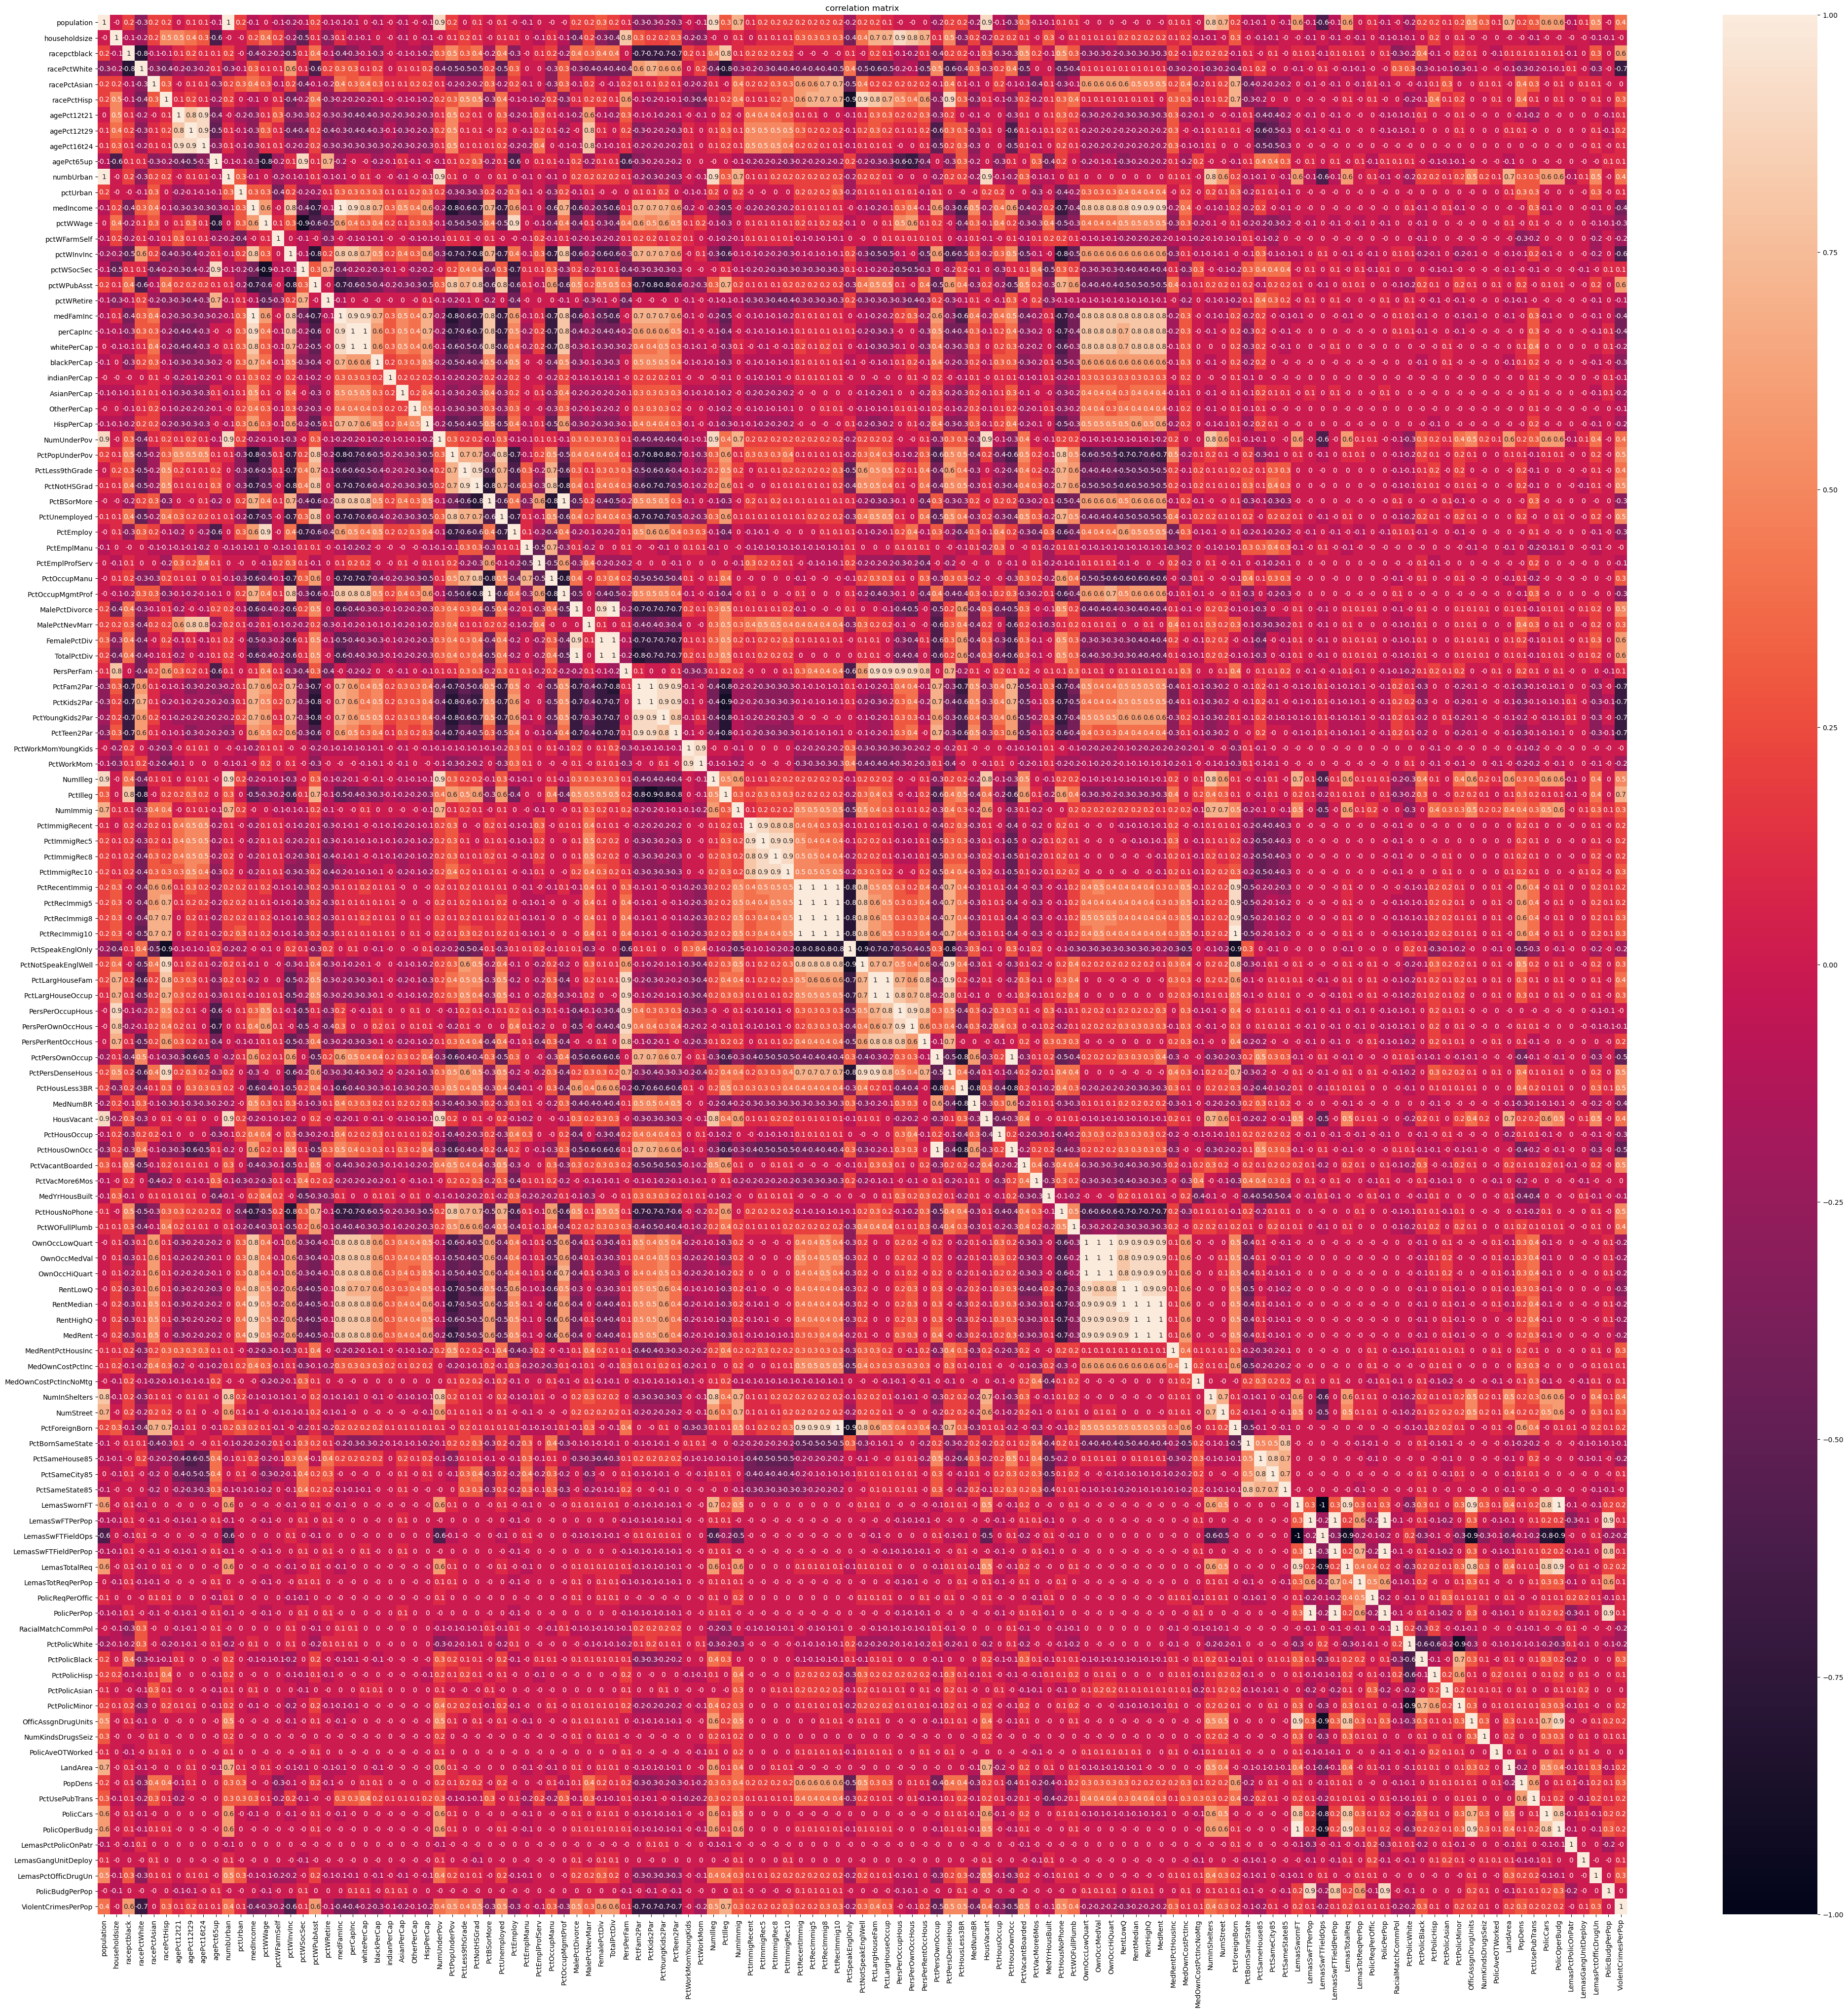

In [19]:
fig = plt.figure() 
plt.rcParams["figure.figsize"]=(5,5)
plt.figure(figsize=(50,50))
ax = sns.heatmap(corr.apply(lambda x: round(x,1)),annot=True)
ax.set_title("correlation matrix")
plt.show()

### 2.d Calculate the Coefficient of Variation CV for each feature, where CV = $\frac{s}{m}$, in which s is sample standard deviation and m is sample mean

In [20]:
cv = df_com.std()/df_com.mean()
pd.DataFrame({"cv":cv})

cv
population           2.203503
householdsize        0.353298
racepctblack         1.410920
racePctWhite         0.323782
racePctAsian         1.359162
...                       ...
LemasPctPolicOnPatr  0.122331
LemasGangUnitDeploy  0.368040
LemasPctOfficDrugUn  2.555266
PolicBudgPerPop      0.337281
ViolentCrimesPerPop  0.979015

[123 rows x 1 columns]

### 2.e Pick $\lfloor\sqrt{128}\rfloor$ features with highest CV , and make scatter plots and box plots for them

In [21]:
# Pick features with highest CV
top_num = math.floor(math.sqrt(128))
top_cv = cv.sort_values(ascending=False).head(top_num)
top_f = list(top_cv.index)
df_com_top = df_com[top_f]
df_com_top

NumStreet  NumInShelters  NumIlleg  NumImmig  LemasPctOfficDrugUn  \
0          0.00           0.04      0.04      0.03                 0.32   
1          0.00           0.00      0.00      0.01                 0.00   
2          0.00           0.00      0.01      0.00                 0.00   
3          0.00           0.00      0.03      0.02                 0.00   
4          0.00           0.00      0.00      0.00                 0.00   
...         ...            ...       ...       ...                  ...   
1989       0.00           0.00      0.00      0.01                 0.00   
1990       0.00           0.01      0.03      0.05                 0.00   
1991       0.02           0.06      0.13      0.06                 0.91   
1992       0.01           0.04      0.02      0.06                 0.22   
1993       0.08           0.08      0.11      0.20                 1.00   

      NumUnderPov  population  numbUrban  HousVacant  LandArea  racePctHisp  
0            0.08        0.19       0.20        0.21      0.12         0.17  
1            0.01        0.00       0.02        0.02      0.02         0.07  
2            0.01        0.00       0.00        0.01      0.01         0.04  
3            0.01        0.04       0.06        0.01      0.02         0.10  
4            0.00        0.01       0.02        0.01      0.04         0.05  
...           ...         ...        ...         ...       ...          ...  
1989         0.01        0.01       0.03        0.02      0.01         0.16  
1990         0.04        0.05       0.06        0.03      0.02         0.32  
1991         0.12        0.16       0.17        0.21      0.08         0.25  
1992         0.03        0.08       0.09        0.05      0.03         0.10  
1993         0.16        0.20       0.21        0.12      0.11         0.77  

[1994 rows x 11 columns]

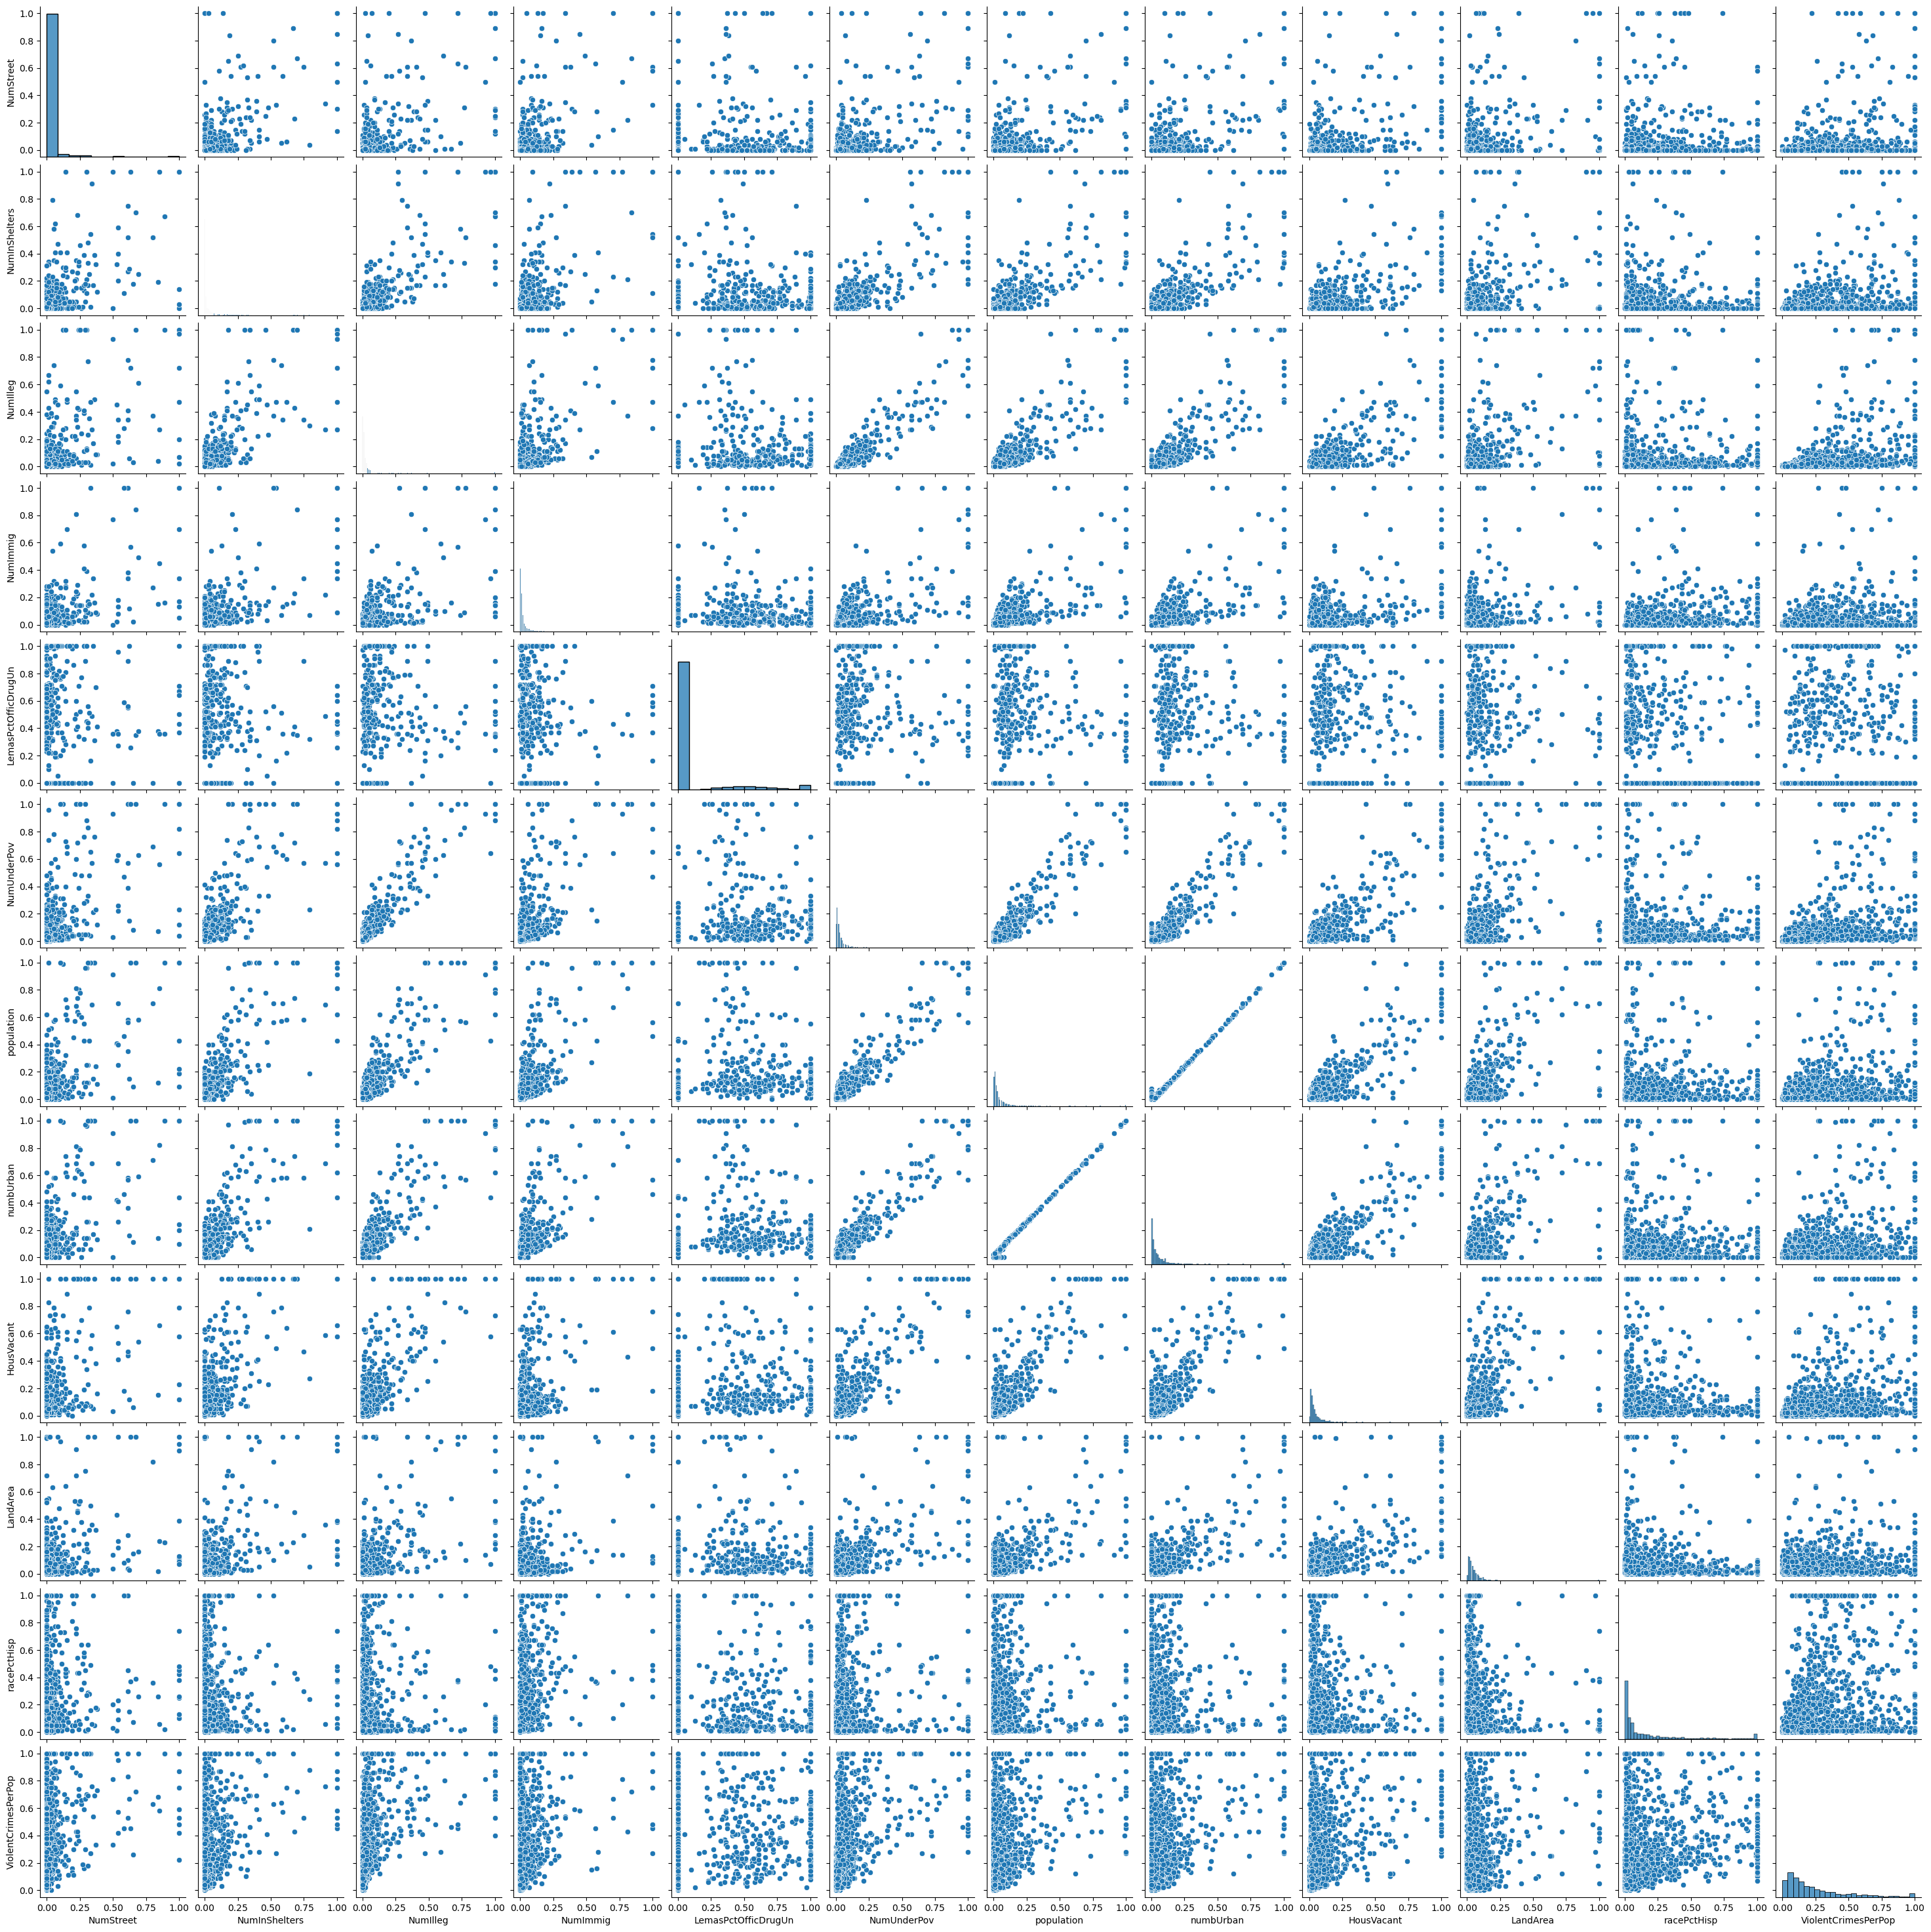

In [22]:
# scatter plots
df_com_top = pd.concat([df_com_top,pd.DataFrame(df_com.iloc[:,-1])],axis=1)
sns.set_context({'figure.figsize':[15, 15]})
sns.pairplot(df_com_top)
plt.show()

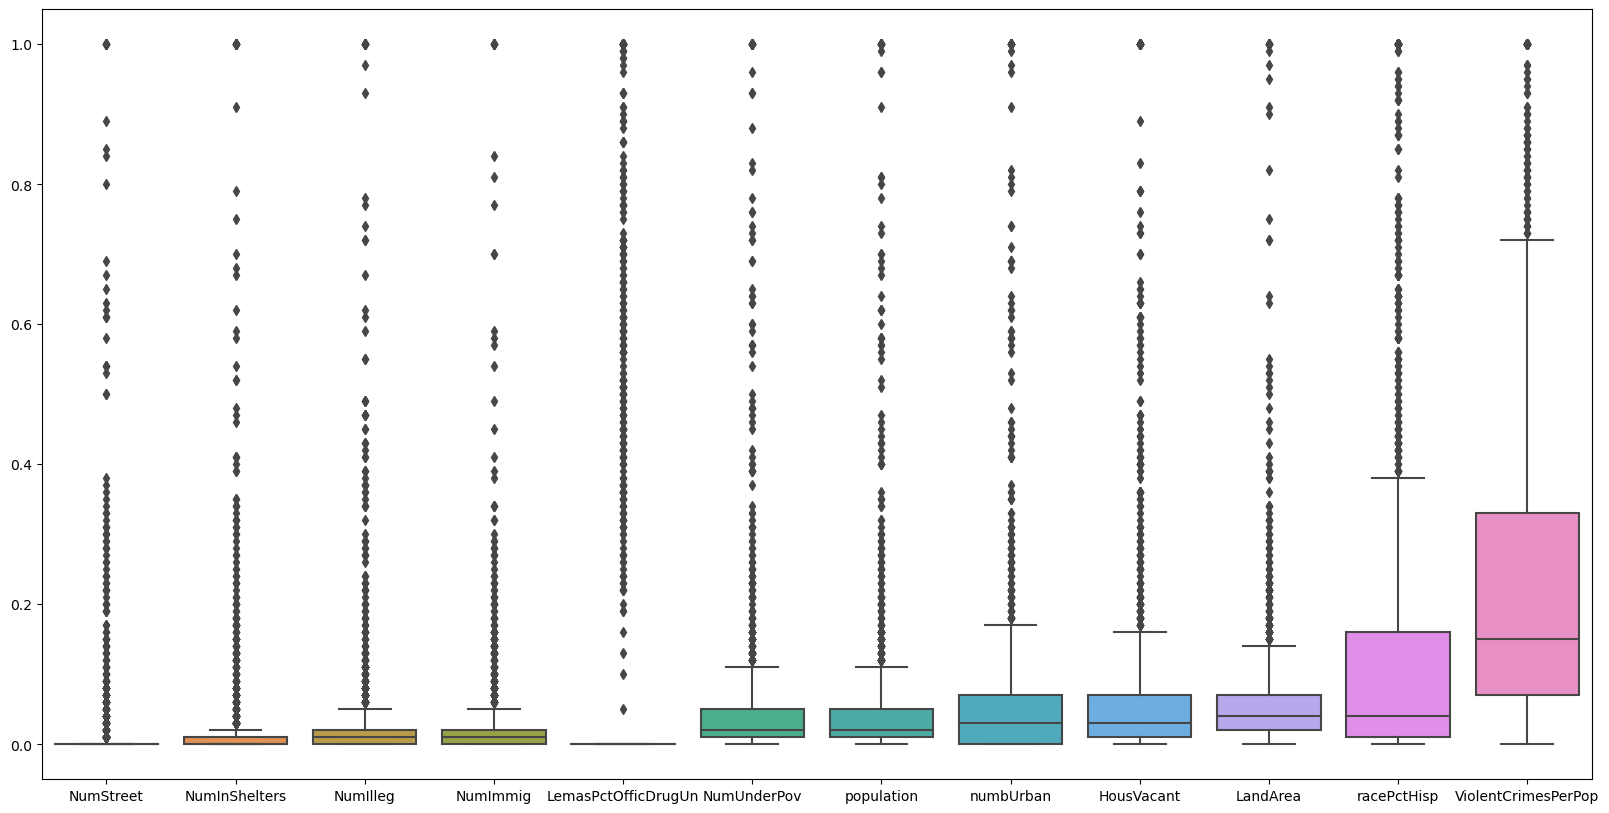

In [23]:
# box plots
ax = sns.boxplot(data=df_com_top)
ax.figure.set_size_inches(20,10)

### Can you draw **conclusions about significance** of those features, just by the scatter plots?

According to the scatter plot, I can't draw conclusion about significance of those features. When considering ViolentCrimesPerPop as the dependent variable, those features' corresponding distribution seem vertical, meaning a specific value of one of those features may correspond many different values of ViolentCrimesPerPop.

### 2.f Fit a linear model using least squares to the training set and report the test error.

In [24]:
com_train = df_com.iloc[:1495]
com_test = df_com.iloc[1495:]
y_train = com_train["ViolentCrimesPerPop"]
x_train = com_train.iloc[:,:-1]
y_test = com_test["ViolentCrimesPerPop"]
x_test = com_test.iloc[:,:-1]

In [25]:
# fit a linear model
lm = sm.OLS(y_train,sm.add_constant(x_train)).fit()
print(lm.summary())

                             OLS Regression Results                            
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.712
Model:                             OLS   Adj. R-squared:                  0.686
Method:                  Least Squares   F-statistic:                     27.78
Date:                 Fri, 28 Oct 2022   Prob (F-statistic):          6.88e-291
Time:                         14:18:07   Log-Likelihood:                 957.23
No. Observations:                 1495   AIC:                            -1668.
Df Residuals:                     1372   BIC:                            -1015.
Df Model:                          122                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [26]:
y_pred = lm.predict(sm.add_constant(x_test))
MSE = mean_squared_error(y_test,y_pred)
MSE

0.7897255275242602

### 2.g  Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [27]:
# fit a ridge model and choose λ by cross-validation
ridgecv = RidgeCV(alphas=np.arange(0.01,100,0.01),cv=5)
ridgecv.fit(x_train,y_train)

RidgeCV(alphas=array([1.000e-02, 2.000e-02, 3.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01]),
        cv=5)

In [28]:
# display the best lambda
alpha = ridgecv.alpha_
alpha

2.29

In [29]:
# refit a ridge model with chosen λ
ridge = Ridge(alpha=alpha)
ridge.fit(x_train,y_train)
y_pred = ridge.predict(x_test)
MSE_ridge = mean_squared_error(y_test,y_pred)
MSE_ridge

0.01760438976807106

### 2.h Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model.

In [30]:
# fit a lasso model and choose λ by cross-validation
lassocv = LassoCV(alphas=np.arange(0.01,100,0.01),cv=5)
lassocv.fit(x_train,y_train)

LassoCV(alphas=array([1.000e-02, 2.000e-02, 3.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01]),
        cv=5)

In [31]:
# display the best lambda
alpha = lassocv.alpha_
alpha

0.01

In [32]:
# refit a ridge model with chosen λ
lasso = Lasso(alpha=alpha)
lasso.fit(x_train,y_train)
y_pred = lasso.predict(x_test)
MSE_lasso = mean_squared_error(y_test,y_pred)
MSE_lasso

0.020919681104181242

In [33]:
# report variables selected by the model
coefs = pd.DataFrame({"coef":lasso.coef_},index=x_train.columns)
coefs = coefs[coefs["coef"]!=0]
print("variables selected by the model are: ",list(coefs.index))

variables selected by the model are:  ['racePctWhite', 'PctKids2Par', 'PctIlleg']


### Repeat with standardized features(already normalized)

#### repeat ridge regression

In [34]:
x_train_z = (x_train-x_train.mean())/x_train.std()

In [35]:
ridgecv = RidgeCV(alphas=np.arange(0.01,100,0.01),cv=5)
ridgecv.fit(x_train_z,y_train)

RidgeCV(alphas=array([1.000e-02, 2.000e-02, 3.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01]),
        cv=5)

In [36]:
# display the best lambda
alpha = ridgecv.alpha_
alpha

81.26

In [37]:
# refit a ridge model with chosen λ
ridge = Ridge(alpha=alpha)
ridge.fit(x_train_z,y_train)
y_pred = ridge.predict(x_test)
MSE_ridge_z = mean_squared_error(y_test,y_pred)
MSE_ridge_z

0.0355321786600405

#### repeat ridge regression

In [38]:
# fit a lasso model and choose λ by cross-validation
lassocv = LassoCV(alphas=np.arange(0.01,100,0.01),cv=5)
lassocv.fit(x_train_z,y_train)

LassoCV(alphas=array([1.000e-02, 2.000e-02, 3.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01]),
        cv=5)

In [39]:
# display the best lambda
alpha = lassocv.alpha_
alpha

0.01

In [40]:
# refit a ridge model with chosen λ
lasso = Lasso(alpha=alpha)
lasso.fit(x_train_z,y_train)
y_pred = lasso.predict(x_test)
MSE_lasso_z = mean_squared_error(y_test,y_pred)
MSE_lasso_z

0.03616856391263459

In [41]:
# report variables selected by the model
coefs = pd.DataFrame({"coef":lasso.coef_},index=x_train.columns)
coefs = coefs[coefs["coef"]!=0]
print("variables selected by the model are: ",list(coefs.index))

variables selected by the model are:  ['racepctblack', 'racePctWhite', 'pctUrban', 'MalePctDivorce', 'PctKids2Par', 'PctWorkMom', 'PctIlleg', 'PctPersDenseHous', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'MedRentPctHousInc', 'NumStreet', 'PctForeignBorn']


### Report the test error for both cases and compare them.

In [42]:
tes_error = [MSE_ridge,MSE_ridge_z,MSE_lasso,MSE_lasso_z]
test_error_report = pd.DataFrame({"test error":tes_error}
                                 ,index=["ridge regression","ridge regression with standardized features",
                                         "lasso regression","lasso regression with standardized features"])
test_error_report

test error
ridge regression                               0.017604
ridge regression with standardized features    0.035532
lasso regression                               0.020920
lasso regression with standardized features    0.036169

From the report table above, we can see that test errors of regressions without standarizing features are lower than those regressions with standarizing features, meaning that standarizing features doesn't help with fit data.

Besides, after standarizing features we can see that test errors of ridge regression model and lasso regression model are becoming closer to each other, meaning that standarization narrows the gap of effects of two models.

### 2.i Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [44]:
# fit PCR model and choose M by k-fold
kf=KFold(n_splits=10)
cv_sore = {}
for n in range(1,123,1):
    pca = PCA(n_components=n)
    score=cross_val_score(LinearRegression(),pca.fit_transform(x_train),y_train,cv=kf)
    cv_sore[n] = score.mean()
print(cv_sore)

{1: 0.327793241521105, 2: 0.4559107415468279, 3: 0.5094516909872053, 4: 0.5675183051749406, 5: 0.5897648745468275, 6: 0.5979726466902126, 7: 0.6433485745695895, 8: 0.6424161105451399, 9: 0.6437610274583504, 10: 0.6451277351180589, 11: 0.6450227430870632, 12: 0.6442671897611387, 13: 0.6458650033644932, 14: 0.6456450374457237, 15: 0.6454700838981338, 16: 0.6451916697922778, 17: 0.6449293688817006, 18: 0.6441749022868773, 19: 0.6438203275013954, 20: 0.6428880400251927, 21: 0.6423155699471108, 22: 0.6427577070645096, 23: 0.6465581391897997, 24: 0.6463837942510072, 25: 0.6453680045232314, 26: 0.6451997522655855, 27: 0.645410337741022, 28: 0.6464990624790132, 29: 0.645622382650788, 30: 0.6484435621418758, 31: 0.6474335894042607, 32: 0.6475172771678752, 33: 0.647378319999899, 34: 0.6464415614536407, 35: 0.6467536982021173, 36: 0.6458830057728475, 37: 0.6460095611808657, 38: 0.6467624071111249, 39: 0.6477014535882252, 40: 0.6463928497577307, 41: 0.6471309448135403, 42: 0.6480996671433734, 43: 

In [45]:
best_m = max(cv_sore,key=cv_sore.get)
print("so according to k-fold, the best m is:",best_m,
      ", and its corresponding cross-validation score is:",cv_sore[best_m])

so according to k-fold, the best m is: 96 , and its corresponding cross-validation score is: 0.6576160131481323


In [46]:
# refit PCR using m=121
pca = PCA(n_components=best_m)
pca.fit(x_train)

PCA(n_components=96)

In [47]:
# get test error
new_x = pca.fit_transform(x_train)
lm = sm.OLS(y_train,sm.add_constant(new_x)).fit()
y_pred = lm.predict(sm.add_constant(pca.transform(x_test)))
MSE_pca = mean_squared_error(y_test,y_pred)
MSE_pca

0.018481029133448883

### 2.j In this section, we would like to fit a boosting tree to the data. 
As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. 

### You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

Some hints on installing XGBoost on Windows: https://picnet.com.au/blog/xgboost-windows-x64-binaries-for-download/

In [49]:
# choose alpha
xgbmodel = xgb.XGBRegressor()
param_grid = {"alpha":np.arange(0.01,10,0.01)} 
grid_search = GridSearchCV(xgbmodel,param_grid,cv=5)
grid_search = grid_search.fit(x_train,y_train)
alpha = grid_search.best_params_["alpha"]
alpha

3.65

In [50]:
# refit with choosen alphs
xgbmodel = xgb.XGBRegressor(alpha=alpha)
xgbmodel = xgbmodel.fit(x_train,y_train)
y_pred = xgbmodel.predict(x_test)
MSE_xgb = mean_squared_error(y_test,y_pred)
MSE_xgb

0.017469797327688677